## 1. Import Libraries/ Dataset

a. Import the required libraries and the dataset (use Google Drive if required).

b. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [ ]:
#from google.colab import drive

# mount google drive
#drive.mount('./drive')

In [ ]:
import pandas as pd

# set filepath
filepath='./drive/MyDrive/Datasets/IMDB Dataset.csv'

# load csv file in dataframe
df = pd.read_csv(filepath)
df.sentiment.value_counts()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2. Data Visualization
  
a. Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

b. Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment. (recommended - matplotlib/seaborn libraries)

c. Any other visualizations that seem appropriate for this problem are encouraged but not necessary, for the points.

d. Print the shapes of train and test data.


 Printing sample (2) movie reivews for class:  positive
0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
Name: review, dtype: object 


 Printing sample (2) movie reivews for class:  negative
3    Basically there's a family where a little boy ...
7    This show was an amazing, fresh & innovative i...
Name: review, dtype: object 

Review shape:  (50000,)
Sentiment shape:  (50000,) 



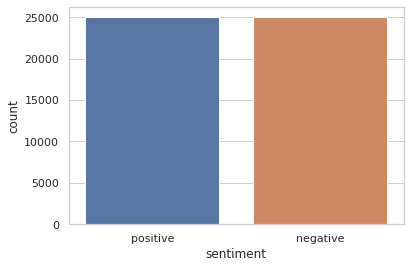

In [ ]:
import seaborn as sns

# print at leat two movie reviews from each class of the dataset,
# for a sanity check that labels match the text
for cls in df['sentiment'].unique():
  print('\n', 'Printing sample (2) movie reivews for class: ', cls)
  print(df[df['sentiment'] == cls]['review'].head(2), '\n')

# Plot a bar graph of class distribution in a dataset.
# Each bar depicts the number of tweets belonging to a particular sentiment.
sns.set_theme(style="whitegrid")
ax = sns.countplot(data=df, x="sentiment")

x_data = df['review']       # Reviews/Input
y_data = df['sentiment']    # Sentiment/Output

# print shape of train and test data
print('Review shape: ', x_data.shape)
print('Sentiment shape: ', y_data.shape, '\n')

## 3. Data Pre-processing

a. Need for this Step - Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step. The discussion of different ways of handling this step is out of the scope of this assignment.

b. Please use this pre-trained embedding layer from TensorFlow hub for this assignment. This link also has a code snippet on how to convert a sentence to a vector. Refer to that for further clarity on this subject.

c. Bring the train and test data in the required format.

In [ ]:
#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords

# pre-process review
#english_stops = set(stopwords.words('english')) # declare stop words
#x_data = x_data.replace({'<.*?>': ''}, regex = True) # remove html tag
df['review'] = df['review'].replace({'<.*?>': ''}, regex = True) # remove html tag
#x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True) # remove non alphabet
df['review'] = df['review'].replace({'[^A-Za-z]': ' '}, regex = True) # remove non alphabet
#x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops]) # remove stop words
#df['review'] = df['review'].apply(lambda review: [w for w in review.split() if w not in english_stops]) # remove stop words
#x_data = x_data.apply(lambda review: [w.lower() for w in review]) # lower case
#df['review'] = df['review'].apply(lambda review: [w.lower() for w in review]) # lower case

# encode sentiment
#y_data = y_data.replace('positive', 1)
df['sentiment'] = df['sentiment'].replace('positive', 1)
#y_data = y_data.replace('negative', 0)
df['sentiment'] = df['sentiment'].replace('negative', 0)

# print dataset
#print('\n', 'Reviews')
#print(x_data)
#print('\n', 'Sentiment')
#print(y_data)
#df.head(2)

In [ ]:
#from sklearn.model_selection import train_test_split

# split dataset
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3)
x_train = df['review'][:35000]
y_train = df['sentiment'][:35000]
x_test = df['review'][35000:]
y_test = df['sentiment'][35000:]

# print training set
print('Train Set')
print(x_train, '\n')
print(y_train, '\n')

# print test set
print('Test Set')
print(x_test, '\n')
print(y_test)

Train Set
0        One of the other reviewers has mentioned that ...
1        A wonderful little production  The filming tec...
2        I thought this was a wonderful way to spend ti...
3        Basically there s a family where a little boy ...
4        Petter Mattei s  Love in the Time of Money  is...
                               ...                        
34995    Awful  Awful  Awful show   Real world  issues ...
34996    I like action movies  I have a softspot for  B...
34997    It begins on a nice note only to falter quickl...
34998    Aardman does it again  Next to Pixar  Aardman ...
34999    This movie made me laugh so much  It was a blo...
Name: review, Length: 35000, dtype: object 

0        1
1        1
2        1
3        0
4        1
        ..
34995    0
34996    0
34997    0
34998    1
34999    0
Name: sentiment, Length: 35000, dtype: int64 

Test Set
35000    Just don t bother  I thought I would see a mov...
35001    Be careful with this one  Once you get yer mit...
3

In [ ]:
import os
import numpy as np # linear algebra
import random
from tensorflow.keras.preprocessing.text import Tokenizer # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences # to do padding or truncating

# set model parameters
num_vocab_size = 10000
num_embedding_dim = 16
str_oov_tok = '<OOV>'
str_trunk_type ='post'
str_pad_type = 'post'

# funtion for resetting random seeds
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

#make some random data
reset_random_seeds()

# function for setting maximum review length
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))
    return int(np.ceil(np.mean(review_length)))

# encode review, no need to lower because already lowered the data in load_data()
token = Tokenizer(num_words=num_vocab_size, oov_token=str_oov_tok, lower=True)
#token.fit_on_texts(x_data)
token.fit_on_texts(df['review'])
#x_train = token.texts_to_sequences(x_train)
#x_test = token.texts_to_sequences(x_test)
sequences = token.texts_to_sequences(df['review'])

df['review_len'] = 0
df['review_len'] = df['review'].map(lambda x: len(x))

#word_index = token.word_index
#total_words = len(word_index) + 1   # add 1 because of 0 padding

#max_length = get_max_length()
#x_train = pad_sequences(x_train, maxlen=max_length, padding=str_pad_type, truncating=str_trunk_type)
#x_test = pad_sequences(x_test, maxlen=max_length, padding=str_pad_type, truncating=str_trunk_type)
#print('Encoded Review Train\n', x_train, '\n')
#print('Encoded Review Test\n', x_test, '\n')
#print('Maximum review length: ', max_length)

df.head(2)
df.describe()

,sentiment,review_len
count,50000.000000,50000.000000
mean,0.500000,1285.174760
std,0.500005,971.140524
min,0.000000,32.000000
25%,0.000000,689.000000
50%,0.500000,953.000000
75%,1.000000,1559.000000
max,1.000000,13584.000000


## 4. Model Building
a. Sequential Model layers - Use AT LEAST 3 hidden layers with appropriate input for each. Choose the best number for hidden units and give reasons.

b. Add L2 regularization to all the layers.

c. Add one layer of dropout at the appropriate position and give reasons.

d. Choose the appropriate activation function for all the layers.

e. Print the model summary.

**To be done:**

Add one layer of dropout at the appropriate position and give reasons.

Choose the best number for hidden units and give reasons.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Reshape

# set model parameters
num_batch_size = 128
num_epochs=10
#num_steps_per_epoch=274 # total training inputs/ batch size = 35000/128
#num_val_steps=118 # total validation inputs/ batch size = 15000/128
num_dropout=0.2
num_l2_reg_penalty=0.0001
num_lr=1e-4
opt = keras.optimizers.Adam(learning_rate=num_lr)
str_loss = 'binary_crossentropy'

print('X_train shape: ', x_train.shape)
print('Y_train shape: ', y_train.shape)

# import pre-trained embedding layer
#embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2",
                           input_shape=[], dtype=tf.string)

# build model
model = keras.Sequential()
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
#model.add(Reshape((35000, max_length)))
model.add(hub_layer)
# add dropout
#model.add(Dropout(num_dropout))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)))
#model.add(keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)))
model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(num_l2_reg_penalty)))

# print model summary
model.summary()

X_train shape:  (35000,)
Y_train shape:  (35000,)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 124,644,769
Trainable params: 2,081
Non-trainable params: 124,642,688
_________________________________________________________________


## 5. Model Compilation
a. Compile the model with the appropriate loss function.

b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.

c. Use accuracy as a metric.

**To be done:**

Give reasons for the choice of learning rate and its value.

In [ ]:
# compile model
model.compile(optimizer = opt, loss = str_loss, metrics = ['accuracy'])

## 6. Model Training
a. Train the model for an appropriate number of epochs. Print the train and validation accuracy and loss for each epoch. Use the appropriate batch size.

b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint   # save model

# checkpoint callback
checkpoint = ModelCheckpoint(
    'models/LSTM.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

# early stopping allback
stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

# timing callback class
class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# timing callback
timing = TimingCallback()

# train model
#history = model.fit(x_train, y_train, batch_size = 128, epochs = 5, callbacks=[checkpoint])
history = model.fit(x_train, y_train, batch_size = num_batch_size, epochs = num_epochs, validation_data=(x_test, y_test), callbacks=[stopping, checkpoint, timing])

# total training time
print('\n', 'Total time taken for training: {:.2f}'.format(sum(timing.logs)), 'seconds', '\n')

Epoch 1/10
274/274 [==============================] - 4s 13ms/step - loss: 0.6924 - accuracy: 0.5376 - val_loss: 0.6682 - val_accuracy: 0.6647

Epoch 00001: accuracy improved from -inf to 0.58174, saving model to models/LSTM.h5
Epoch 2/10
274/274 [==============================] - 3s 13ms/step - loss: 0.6580 - accuracy: 0.6866 - val_loss: 0.6269 - val_accuracy: 0.7224

Epoch 00002: accuracy improved from 0.58174 to 0.70234, saving model to models/LSTM.h5
Epoch 3/10
274/274 [==============================] - 3s 13ms/step - loss: 0.6168 - accuracy: 0.7262 - val_loss: 0.5829 - val_accuracy: 0.7486

Epoch 00003: accuracy improved from 0.70234 to 0.73471, saving model to models/LSTM.h5
Epoch 4/10
274/274 [==============================] - 3s 13ms/step - loss: 0.5736 - accuracy: 0.7514 - val_loss: 0.5461 - val_accuracy: 0.7679

Epoch 00004: accuracy improved from 0.73471 to 0.75709, saving model to models/LSTM.h5
Epoch 5/10
274/274 [==============================] - 4s 13ms/step - loss: 0.53

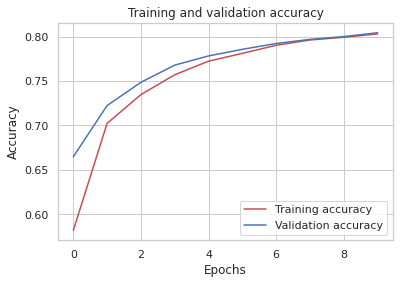

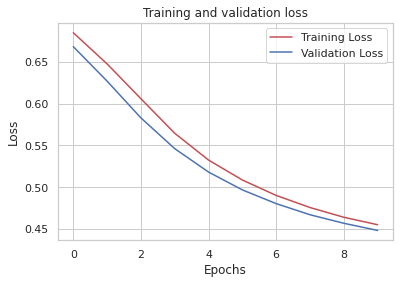

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy history graph for training and validation
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc=0)
plt.figure()

# Loss history graph for training and validation
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()

# show plot
plt.show()

## 7. Model Evaluation
a. Print the final train and validation loss and accuracy. Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

b. Print the two most incorrectly classified texts for each class in the test dataset.

**To be done:**

Print confusion matrix and classification report for the validation dataset. Analyse and report the best and worst performing class.

Print the two most incorrectly classified texts for each class in the test dataset.

In [ ]:
# final training accuracy and loss
#print(history.history.keys())
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
print('Final Training Accuracy: {:.2f}'.format(accuracy[num_epochs-1]))
print('Final Training Loss: {:.2f}'.format(loss[num_epochs-1]))
print('Final Validation Accuracy: {:.2f}'.format(val_accuracy[num_epochs-1]))
print('Final Validation Loss: {:.2f}'.format(val_loss[num_epochs-1]))

Final Training Accuracy: 0.80
Final Training Loss: 0.46
Final Validation Accuracy: 0.80
Final Validation Loss: 0.45


In [ ]:
# confusion matrix


# classification report


In [ ]:
# two most incorrectly classified texts for each class in the test dataset
score = model.evaluate(x_test, y_test)

469/469 [==============================] - 2s 4ms/step - loss: 0.4482 - accuracy: 0.8044
